### DATA Initiative Research Assistant Task 2

                                Shreyas Sreenivas
                                002825934

In [18]:
# Necessary import statements
import os
import re
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer, BertModel
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from nltk.stem import PorterStemmer
import warnings

warnings.filterwarnings("ignore")

------------------------------------------------------------------
#### Reading the data
------------------------------------------------------------------

In [10]:
# Data Paths
questions_csv_path = r'E:\Documents\Prof_Docs\DATA analysis test\Round 2 Docs\ground-truth.xlsx - Form Responses 1.csv'
text_csv_path = r'E:\Documents\Prof_Docs\DATA analysis test\Round 2 Docs\Sample.csv'
video_dir = r'E:\Documents\Prof_Docs\DATA analysis test\Round 2 Docs\sample\sample'

# Loading the Data
df_questions = pd.read_csv(questions_csv_path)
df_text = pd.read_csv(text_csv_path)

------------------------------------------------------------------
#### Data Pre-Processing
------------------------------------------------------------------

In [11]:
# Normalize Text Data
stemmer = PorterStemmer()

def normalize_text(text):
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    return ' '.join([stemmer.stem(word) for word in text.split()])

df_text['speech_normalized'] = df_text['speech'].apply(normalize_text)

# Defining binary conversion
def convert_to_binary(value):
    if isinstance(value, str) and value.lower().startswith('yes'):
        return 1
    elif value.lower() == 'no':
        return 0
    return value

# Apply the conversion to the relevant columns (specified questions) in the questions CSV
question_columns = [
    "Is there a call to go online (e.g., shop online, visit the Web)? ",
    "Is there online contact information provided (e.g., URL, website)? ",
    "Is there a visual or verbal call to purchase (e.g., buy now, order now)?",
    "Does the ad portray a sense of urgency to act (e.g., buy before sales end, order before it ends)? ",
    "Is there an incentive to buy (e.g., a discount, a coupon, a sale, or 'limited time offer')? ",
    "Is there offline contact information provided (e.g., phone, mail, store location)?",
    "Is there mention of something free? ",
    "Does the ad mention at least one specific product or service (e.g., model, type, item)? ",
    "Is there any verbal or visual mention of the price?",
    'Does the ad show the brand (logo, brand name) or trademark (something that most people know is the brand) multiple times?\n\nFor example, Nike ads often have the "swoosh" logo prominently displayed on shoes and apparel worn by celebrity athletes. The "Just Do It" slogan is another Nike trademark frequently included.',
    "Does the ad show the brand or trademark exactly once at the end of the ad?",
    "Is the ad intended to affect the viewer emotionally, either with positive emotion (fun, joy), negative emotion (sad, anxious) or another type of emotion? (Note: You may not personally agree, but assess if that was the intention.)",
    "Does the ad give you a positive feeling about the brand? ",
    "Does the ad have a story arc, with a beginning and an end? ",
    "Does the ad have a reversal of fortune, where something changes for the better, or changes for the worse?",
    "Does the ad have relatable characters? ",
    "Is the ad creative/clever?",
    "Is the ad intended to be funny? (Note: You may not personally agree, but assess if that was the intention.)",
    "Does this ad provide sensory stimulation (e.g., cool visuals, arousing music, mouth-watering)? ",
    "Is the ad visually pleasing?",
    "Does the ad have cute elements like animals, babies, animated, characters, etc?"
]

for column in question_columns:
    df_questions[column] = df_questions[column].apply(convert_to_binary)

# Merging the dataframes on the common identifier (in this case creative_data_id)
df_merged = pd.merge(df_questions, df_text, on='creative_data_id')
df_merged['video_file'] = df_merged['creative_data_id'].apply(lambda x: os.path.join(video_dir, f"{x}.mp4"))

# Extracting the relevant columns
video_files = df_merged['video_file'].tolist()
extracted_texts = df_merged['speech'].tolist()
labels = df_merged[question_columns].values.tolist()

df_merged.to_csv("Merged_Data.csv", index=False)
print("Merged data saved to Merged_Data.csv")

Merged data saved to Merged_Data.csv


In [12]:
df_merged.head()

,Timestamp,creative_data_id,"Is there a call to go online (e.g., shop online, visit the Web)?","Is there online contact information provided (e.g., URL, website)?","Is there a visual or verbal call to purchase (e.g., buy now, order now)?","Does the ad portray a sense of urgency to act (e.g., buy before sales end, order before it ends)?","Is there an incentive to buy (e.g., a discount, a coupon, a sale, or 'limited time offer')?","Is there offline contact information provided (e.g., phone, mail, store location)?",Is there mention of something free?,"Does the ad mention at least one specific product or service (e.g., model, type, item)?",...,creative_data_title,creative_data_description,creative_data_duration,creative_data_lifetime_spend_estimated,creative_data_lifetime_airings_count,creative_data_airing_date_first_et,creative_data_airing_date_last_et,speech,speech_normalized,video_file
0,5/16/2024 8:00:14,1471363,0,1,0,0,0,0,0,1,...,30s Add Stories [T1] - 1471363,"The new MINI Countryman is the largest yet, pr...",30,7863776.27,2788,2017-02-02T21:20:48-05:00,2018-07-09T08:50:58-04:00,It's another pure gray morning. Don't know wha...,it anoth pure gray morn dont know what the day...,E:\Documents\Prof_Docs\DATA analysis test\Roun...
1,5/23/2024 2:35:55,1471363,0,1,0,0,0,0,0,1,...,30s Add Stories [T1] - 1471363,"The new MINI Countryman is the largest yet, pr...",30,7863776.27,2788,2017-02-02T21:20:48-05:00,2018-07-09T08:50:58-04:00,It's another pure gray morning. Don't know wha...,it anoth pure gray morn dont know what the day...,E:\Documents\Prof_Docs\DATA analysis test\Roun...
2,5/15/2024 18:09:54,1488315,0,0,0,0,0,0,0,0,...,30s Last Days - 1488315,What would you do if the end of the world was ...,30,20925675.98,3699,2017-03-05T06:37:33-05:00,2018-06-11T03:09:14-04:00,The end of civilization is upon us. Hold your ...,the end of civil is upon us hold your love one...,E:\Documents\Prof_Docs\DATA analysis test\Roun...
3,5/16/2024 6:18:34,1488315,0,0,0,0,0,0,0,1,...,30s Last Days - 1488315,What would you do if the end of the world was ...,30,20925675.98,3699,2017-03-05T06:37:33-05:00,2018-06-11T03:09:14-04:00,The end of civilization is upon us. Hold your ...,the end of civil is upon us hold your love one...,E:\Documents\Prof_Docs\DATA analysis test\Roun...
4,5/24/2024 10:00:26,1488315,0,0,0,0,0,0,0,1,...,30s Last Days - 1488315,What would you do if the end of the world was ...,30,20925675.98,3699,2017-03-05T06:37:33-05:00,2018-06-11T03:09:14-04:00,The end of civilization is upon us. Hold your ...,the end of civil is upon us hold your love one...,E:\Documents\Prof_Docs\DATA analysis test\Roun...


In [13]:
save_dir = r'E:\Documents\Prof_Docs\DATA analysis test\Round 2 Docs\sample\frames_tensors'
os.makedirs(save_dir, exist_ok=True)

# Extract Frames
def extract_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = torch.tensor(frame).permute(2, 0, 1)
        frames.append(frame)
    cap.release()
    return frames

In [ ]:
# Save frames as tensors
def save_frames_as_tensors(video_path, frames, save_dir):
    video_id = os.path.splitext(os.path.basename(video_path))[0]
    tensor_path = os.path.join(save_dir, f"{video_id}.pt")
    torch.save(frames, tensor_path)

In [14]:
# Load frames from tensors
def load_frames_from_tensors(video_path, save_dir, max_frames=30):
    video_id = os.path.splitext(os.path.basename(video_path))[0]
    tensor_path = os.path.join(save_dir, f"{video_id}.pt")
    frames = torch.load(tensor_path)
    if len(frames) > max_frames:
        frames = frames[:max_frames]
    else:
        padding = max_frames - len(frames)
        frames.extend([torch.zeros_like(frames[0])] * padding)
    return frames

------------------------------------------------------------------
#### Model Architecture
------------------------------------------------------------------

In [15]:
# Multimodal Model
class MultimodalModel(nn.Module):
    def __init__(self, num_classes):
        super(MultimodalModel, self).__init__()
        self.video_model = torchvision.models.resnet18(pretrained=True)
        self.video_model.fc = nn.Linear(self.video_model.fc.in_features, 512)
        self.text_model = BertModel.from_pretrained('bert-base-uncased')
        self.fc = nn.Linear(512 + 768, num_classes)

    def forward(self, video_frames, input_ids, attention_mask):
        video_frames = torch.mean(video_frames, dim=1)
        video_features = self.video_model(video_frames)
        text_outputs = self.text_model(input_ids=input_ids, attention_mask=attention_mask)
        text_features = text_outputs.pooler_output
        combined_features = torch.cat((video_features, text_features), dim=1)
        return self.fc(combined_features)

# Dataset Preparation
class MultimodalDataset(Dataset):
    def __init__(self, video_paths, texts, labels, tokenizer, transform=None):
        self.video_paths = video_paths
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.transform = transform

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        text = self.texts[idx]
        labels = self.labels[idx]
        label_tensor = torch.tensor([float(label) for label in labels], dtype=torch.float32)

        frames = load_frames_from_tensors(video_path, save_dir)
        if self.transform:
            frames = [self.transform(frame) for frame in frames]
        video_frames = torch.stack(frames)

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=128,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()

        return video_frames, input_ids, attention_mask, label_tensor

------------------------------------------------------------------
#### Training and Evaluating the model
------------------------------------------------------------------

In [16]:
# Initialize tokenizer and transform
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Data Loader Setup
dataset = MultimodalDataset(df_merged['video_file'].tolist(), df_merged['speech_normalized'].tolist(), df_merged[question_columns].values.tolist(), tokenizer, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Model Training
num_classes = len(question_columns)
model = MultimodalModel(num_classes)

model.load_state_dict(torch.load('best_model_state_dict.pth'))

model = model.cuda()

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scaler = torch.cuda.amp.GradScaler()

num_epochs = 10
best_val_loss = float('inf')
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (video_frames, input_ids, attention_mask, label_tensor) in enumerate(train_loader):
        video_frames, input_ids, attention_mask, label_tensor = video_frames.cuda(), input_ids.cuda(), attention_mask.cuda(), label_tensor.cuda()

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(video_frames, input_ids, attention_mask)
            loss = criterion(outputs, label_tensor)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()

        if i % 10 == 9:  # Log after every 10 batches
            print(f'Epoch {epoch+1}, Batch {i+1}, Loss: {running_loss / 10:.4f}')
            running_loss = 0.0

    # Validation
    model.eval()
    total_val_loss = 0.0
    val_labels = []
    val_outputs = []
    with torch.no_grad():
        for video_frames, input_ids, attention_mask, label_tensor in val_loader:
            video_frames, input_ids, attention_mask, label_tensor = video_frames.cuda(), input_ids.cuda(), attention_mask.cuda(), label_tensor.cuda()
            outputs = model(video_frames, input_ids, attention_mask)
            batch_loss = criterion(outputs, label_tensor)
            total_val_loss += batch_loss.item()
            val_labels.extend(label_tensor.cpu().numpy())
            val_outputs.extend(outputs.sigmoid().cpu().numpy())

    # Calculating average validation loss
    avg_val_loss = total_val_loss / len(val_loader)
    print(f'Epoch {epoch+1}, Average Validation Loss: {avg_val_loss:.4f}')

    # Saving the model if improved
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model_state_dict.pth')
        print(f"Model improved and saved at Epoch {epoch+1} with Validation Loss: {avg_val_loss:.4f}")

    val_labels = np.array(val_labels)
    val_outputs = np.array(val_outputs)
    val_outputs = (val_outputs > 0.5).astype(int)

    f1 = f1_score(val_labels, val_outputs, average='macro')
    precision = precision_score(val_labels, val_outputs, average='macro', zero_division=0)
    recall = recall_score(val_labels, val_outputs, average='macro')

    agreement = np.mean([np.array_equal(val_labels[i], val_outputs[i]) for i in range(len(val_labels))]) * 100

    print(f'Epoch {epoch+1}, Validation F1 Score: {f1:.4f}')
    print(f'Epoch {epoch+1}, Validation Precision: {precision:.4f}')
    print(f'Epoch {epoch+1}, Validation Recall: {recall:.4f}')
    print(f'Epoch {epoch+1}, Validation Agreement Percentage: {agreement:.4f}')

    # Calculate and print metrics for each question
    print(f'Metrics for Each Question at Epoch {epoch+1}:')
    for i, question in enumerate(question_columns):
        f1_q = f1_score(val_labels[:, i], val_outputs[:, i], zero_division=0)
        precision_q = precision_score(val_labels[:, i], val_outputs[:, i], zero_division=0)
        recall_q = recall_score(val_labels[:, i], val_outputs[:, i], zero_division=0)
        print(f"{question}: F1={f1_q:.4f}, Precision={precision_q:.4f}, Recall={recall_q:.4f}")

print('Finished Training')

Epoch 1, Batch 10, Loss: 0.3804
Epoch 1, Batch 20, Loss: 0.3847
Epoch 1, Average Validation Loss: 0.3993
Model improved and saved at Epoch 1 with Validation Loss: 0.3993
Epoch 1, Validation F1 Score: 0.7382
Epoch 1, Validation Precision: 0.8114
Epoch 1, Validation Recall: 0.7234
Epoch 1, Validation Agreement Percentage: 3.3333
Metrics for Each Question at Epoch 1:
Is there a call to go online (e.g., shop online, visit the Web)? : F1=0.5000, Precision=0.8571, Recall=0.3529
Is there online contact information provided (e.g., URL, website)? : F1=0.8736, Precision=0.9268, Recall=0.8261
Is there a visual or verbal call to purchase (e.g., buy now, order now)?: F1=0.6667, Precision=0.6571, Recall=0.6765
Does the ad portray a sense of urgency to act (e.g., buy before sales end, order before it ends)? : F1=0.7556, Precision=0.7391, Recall=0.7727
Is there an incentive to buy (e.g., a discount, a coupon, a sale, or 'limited time offer')? : F1=0.8000, Precision=0.6667, Recall=1.0000
Is there offli

The above agreement percentage is calculated by checking if all answers for a video perfectly match the ground truth across all questions. This is an "all-or-nothing" approach where each video must have every question correctly predicted to be considered an agreement. It focuses on the complete accuracy per instance (video).

I refer to the model state saved from epoch 1 for the following lines of code

------------------------------------------------------------------
#### Miscellaneous
------------------------------------------------------------------

##### Creating the CSV file with the final answer per video per question

In [17]:
# Creating a DataFrame from the predictions
final_predictions = pd.DataFrame(val_outputs, columns=question_columns)

# Adding the video identifier
final_predictions['creative_data_id'] = [df_merged.iloc[i]['creative_data_id'] for i in val_dataset.indices]

cols = ['creative_data_id'] + question_columns
final_predictions = final_predictions[cols]

final_predictions.to_csv("sreenivas.s_answers.csv", index=False)
print("Final predictions saved to 'sreenivas.s_answers.csv'. This is based on the validation dataset and not the data that was included during training.")

Final predictions saved to 'sreenivas.s_answers.csv'. This is based on the validation dataset and not the data that was included during training.


##### Calculating the agreement percentages for each question for all videos and their average

In [19]:
agreement_percentages = []
for i in range(val_labels.shape[1]):
    question_agreements = val_labels[:, i] == val_outputs[:, i]
    agreement_percentage = np.mean(question_agreements) * 100
    agreement_percentages.append(agreement_percentage)
    print(f"Agreement for Question {i+1}: {agreement_percentage:.2f}%")

average_agreement = np.mean(agreement_percentages)
print(f"Average Agreement across all questions: {average_agreement:.2f}%")

Agreement for Question 1: 73.33%
Agreement for Question 2: 87.78%
Agreement for Question 3: 74.44%
Agreement for Question 4: 87.78%
Agreement for Question 5: 84.44%
Agreement for Question 6: 82.22%
Agreement for Question 7: 96.67%
Agreement for Question 8: 85.56%
Agreement for Question 9: 93.33%
Agreement for Question 10: 77.78%
Agreement for Question 11: 81.11%
Agreement for Question 12: 70.00%
Agreement for Question 13: 83.33%
Agreement for Question 14: 78.89%
Agreement for Question 15: 95.56%
Agreement for Question 16: 60.00%
Agreement for Question 17: 73.33%
Agreement for Question 18: 92.22%
Agreement for Question 19: 76.67%
Agreement for Question 20: 65.56%
Agreement for Question 21: 90.00%
Average Agreement across all questions: 81.43%


This percentage is calculated as the agreement percentage for each question individually across all videos as well as the average across all questions for all videos. This method evaluates how well the model performs for each question separately, regardless of its performance on other questions in the same video.

##### Calculating the AUC score, average precision along with a ROC curve for further analysis

AUC Score: 0.7270
Average Precision: 0.6762


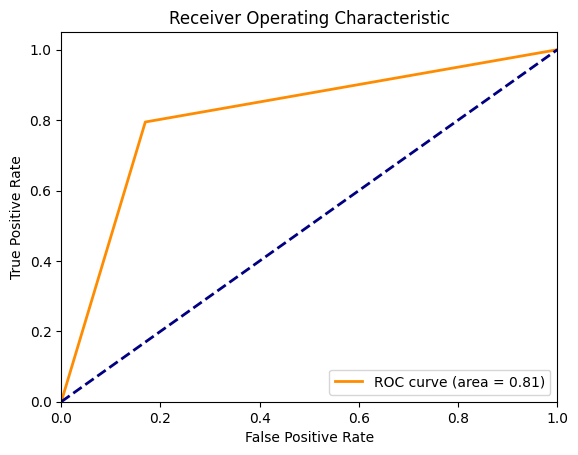

In [20]:
val_predictions = (np.array(val_outputs) > 0.5).astype(int)
auc_score = roc_auc_score(val_labels, val_outputs, average='macro')
avg_precision = average_precision_score(val_labels, val_outputs, average='macro')

print(f"AUC Score: {auc_score:.4f}")
print(f"Average Precision: {avg_precision:.4f}")

# Ensure labels and predictions are 1D arrays if binary classification
if len(val_labels.shape) > 1:  # This checks if the labels are not 1D
    val_labels = val_labels.ravel()
if len(val_predictions.shape) > 1:  # This checks if the predictions are not 1D
    val_predictions = val_predictions.ravel()

# Now calculate the ROC curve
fpr, tpr, thresholds = roc_curve(val_labels, val_predictions)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

##### Calculating a confusion matrix to better understand the accuracy of the model

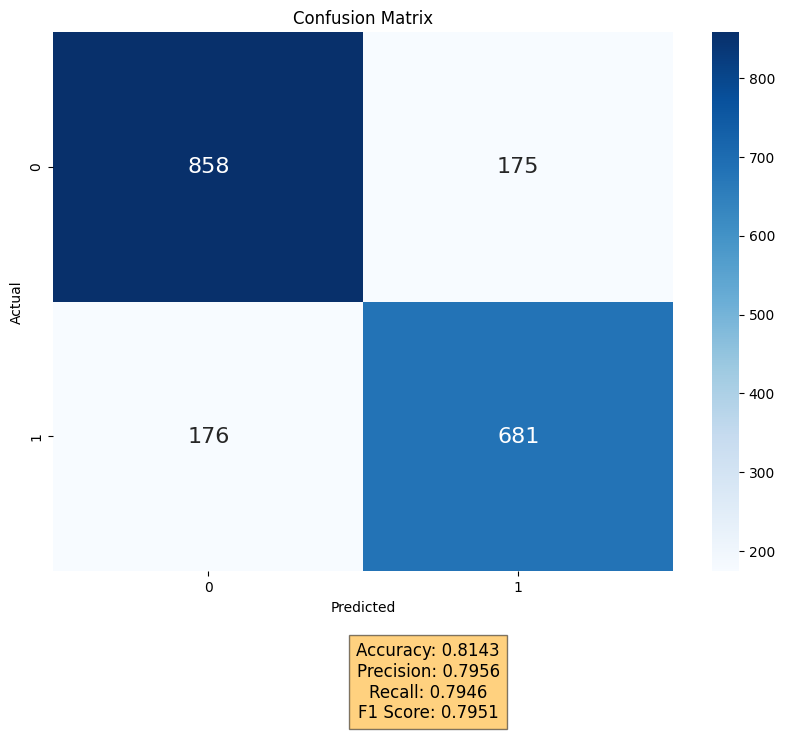

In [21]:
# Calculate confusion matrix
cm = confusion_matrix(val_labels, val_predictions)

# Calculate metrics
accuracy = accuracy_score(val_labels, val_predictions)
precision = precision_score(val_labels, val_predictions)
recall = recall_score(val_labels, val_predictions)
f1 = f1_score(val_labels, val_predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})  # Larger annotations
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Display the metrics
plt.figtext(0.5, -0.1, f'Accuracy: {accuracy:.4f}\nPrecision: {precision:.4f}\nRecall: {recall:.4f}\nF1 Score: {f1:.4f}', 
            ha="center", fontsize=12, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})

plt.show()